Loading Sentinel-2 image...
Image loaded: (877, 1164)
Calculating spectral indices...
Performing edge-based segmentation...


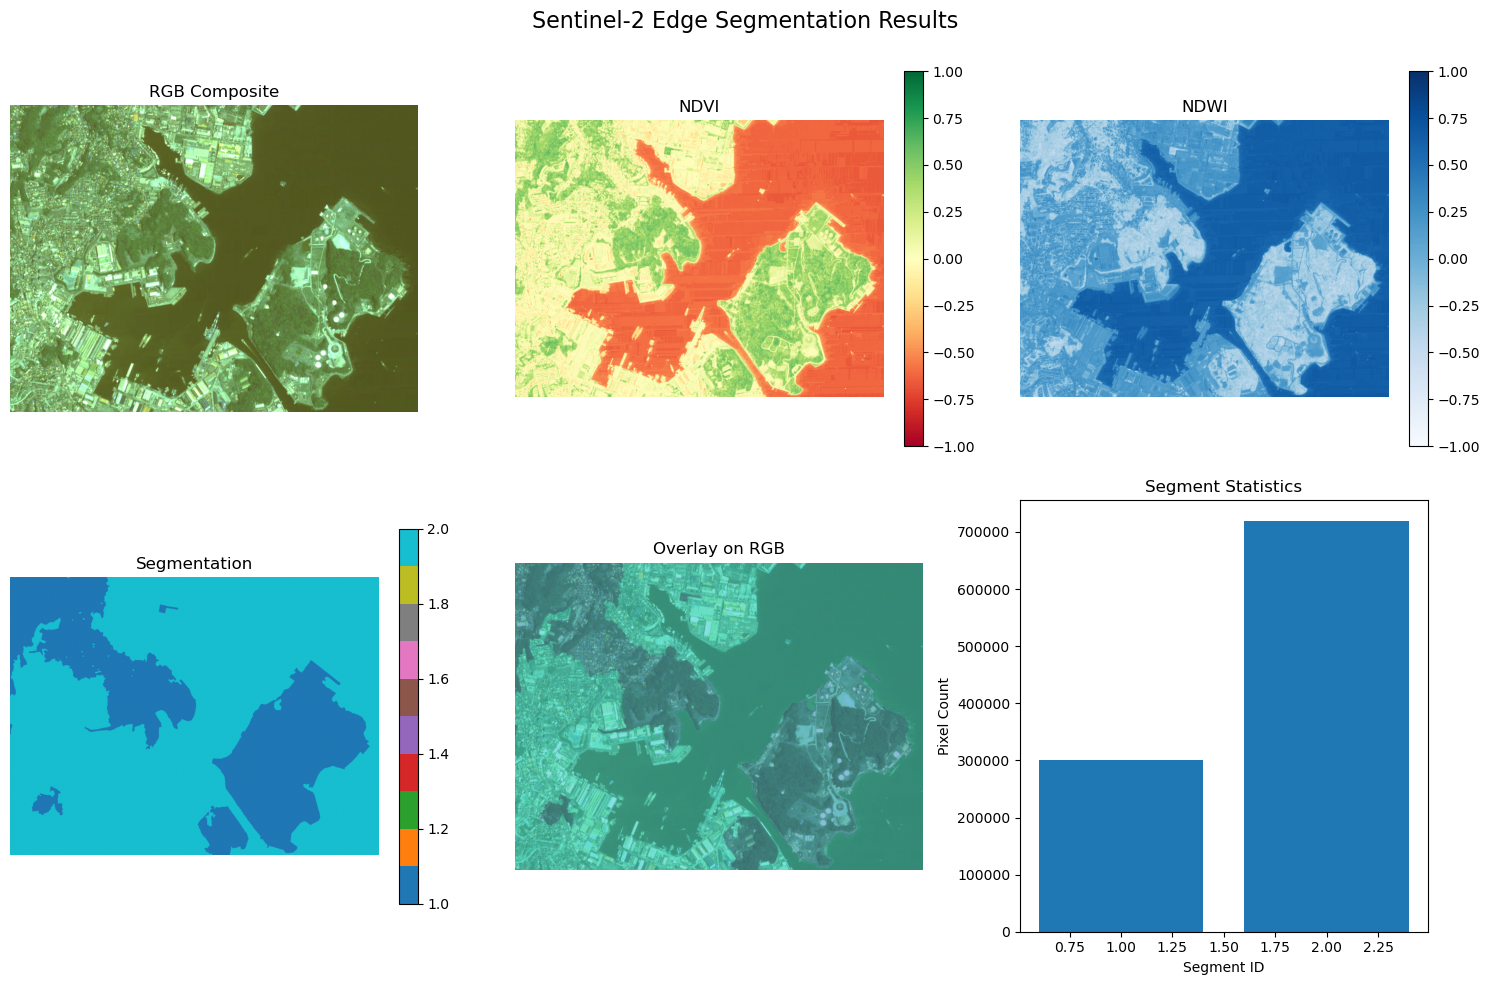


Segmentation Statistics:
segment_1: 301549 pixels, NDVI: 0.316, NDWI: -0.169
segment_2: 719279 pixels, NDVI: -0.326, NDWI: 0.409


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import filters, measure, morphology, segmentation
import rasterio
from rasterio.plot import show
import warnings
warnings.filterwarnings('ignore')

class Sentinel2Segmentation:
    def __init__(self, image_path):
        """
        Initialize the segmentation workflow
        
        Args:
            image_path: Path to Sentinel-2 image file
        """
        self.image_path = image_path
        self.image = None
        self.bands = {}
        self.indices = {}
        self.segments = None
        
    def load_image(self):
        """Load Sentinel-2 image and extract relevant bands"""
        print("Loading Sentinel-2 image...")
        
        with rasterio.open(self.image_path) as src:
            # Read bands (assuming standard Sentinel-2 band order)
            # Band 2: Blue (490nm)
            # Band 3: Green (560nm) 
            # Band 4: Red (665nm)
            # Band 8: NIR (842nm)
            
            self.bands['blue'] = src.read(3).astype(np.float32)
            self.bands['green'] = src.read(2).astype(np.float32)
            self.bands['red'] = src.read(1).astype(np.float32)
            self.bands['nir'] = src.read(4).astype(np.float32)
            
            self.profile = src.profile
            
        print(f"Image loaded: {self.bands['red'].shape}")
        
    def calculate_indices(self):
        """Calculate vegetation and water indices"""
        print("Calculating spectral indices...")
        
        # NDVI (Normalized Difference Vegetation Index)
        ndvi_num = self.bands['nir'] - self.bands['red']
        ndvi_den = self.bands['nir'] + self.bands['red']
        self.indices['ndvi'] = np.divide(ndvi_num, ndvi_den, 
                                       out=np.zeros_like(ndvi_num), 
                                       where=ndvi_den!=0)
        
        # NDWI (Normalized Difference Water Index)
        ndwi_num = self.bands['green'] - self.bands['nir']
        ndwi_den = self.bands['green'] + self.bands['nir']
        self.indices['ndwi'] = np.divide(ndwi_num, ndwi_den,
                                       out=np.zeros_like(ndwi_num),
                                       where=ndwi_den!=0)
        
        # Simple brightness index
        self.indices['brightness'] = (self.bands['red'] + 
                                    self.bands['green'] + 
                                    self.bands['blue']) / 3
        
    def threshold_segmentation(self):
        """Simple threshold-based segmentation"""
        print("Performing threshold segmentation...")
        
        segments = np.zeros_like(self.indices['ndvi'], dtype=np.uint8)
        
        # Water bodies (high NDWI, low NDVI)
        water_mask = (self.indices['ndwi'] > 0.3) & (self.indices['ndvi'] < 0.2)
        segments[water_mask] = 1
        
        # Vegetation (high NDVI)
        vegetation_mask = self.indices['ndvi'] > 0.4
        segments[vegetation_mask] = 2
        
        # Built-up/bare soil (low NDVI, high brightness)
        built_up_mask = (self.indices['ndvi'] < 0.2) & (self.indices['brightness'] > 1000)
        segments[built_up_mask] = 3
        
        # Apply morphological operations to clean up
        segments = morphology.opening(segments, morphology.disk(2))
        segments = morphology.closing(segments, morphology.disk(3))
        
        self.segments = segments
        
    def kmeans_segmentation(self, n_clusters=5):
        """K-means clustering based segmentation"""
        print(f"Performing K-means segmentation with {n_clusters} clusters...")
        
        # Stack all features
        features = np.stack([
            self.bands['red'].flatten(),
            self.bands['green'].flatten(), 
            self.bands['blue'].flatten(),
            self.bands['nir'].flatten(),
            self.indices['ndvi'].flatten(),
            self.indices['ndwi'].flatten()
        ], axis=1)
        
        # Remove invalid pixels
        valid_mask = np.all(np.isfinite(features), axis=1)
        features_clean = features[valid_mask]
        
        # Normalize features
        features_norm = (features_clean - features_clean.mean(axis=0)) / features_clean.std(axis=0)
        
        # Apply K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_norm)
        
        # Reshape back to image dimensions
        segments = np.zeros(self.bands['red'].size, dtype=np.uint8)
        segments[valid_mask] = labels + 1
        segments = segments.reshape(self.bands['red'].shape)
        
        self.segments = segments
        
    def edge_based_segmentation(self):
        """Edge-based segmentation using watershed"""
        print("Performing edge-based segmentation...")
        
        # Use NDVI for edge detection
        ndvi_smooth = filters.gaussian(self.indices['ndvi'], sigma=1)
        edges = filters.sobel(ndvi_smooth)
        
        # Create markers
        markers = np.zeros_like(self.indices['ndvi'], dtype=np.int32)
        
        # High vegetation areas
        markers[self.indices['ndvi'] > 0.6] = 1
        # Water areas  
        markers[self.indices['ndwi'] > 0.4] = 2
        # Built-up areas
        markers[(self.indices['ndvi'] < 0.2) & (self.indices['brightness'] > 1200)] = 3
        
        # Apply watershed
        segments = segmentation.watershed(edges, markers)
        
        self.segments = segments.astype(np.uint8)
        
    def visualize_results(self, method_name="Segmentation"):
        """Visualize the segmentation results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Sentinel-2 {method_name} Results', fontsize=16)
        
        # Original RGB composite
        rgb = np.stack([self.bands['red'], self.bands['green'], self.bands['blue']], axis=2)
        rgb_norm = np.clip(rgb / np.percentile(rgb, 98), 0, 1)
        axes[0, 0].imshow(rgb_norm)
        axes[0, 0].set_title('RGB Composite')
        axes[0, 0].axis('off')
        
        # NDVI
        ndvi_plot = axes[0, 1].imshow(self.indices['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[0, 1].set_title('NDVI')
        axes[0, 1].axis('off')
        plt.colorbar(ndvi_plot, ax=axes[0, 1], fraction=0.046)
        
        # NDWI
        ndwi_plot = axes[0, 2].imshow(self.indices['ndwi'], cmap='Blues', vmin=-1, vmax=1)
        axes[0, 2].set_title('NDWI') 
        axes[0, 2].axis('off')
        plt.colorbar(ndwi_plot, ax=axes[0, 2], fraction=0.046)
        
        # Segmentation results
        seg_plot = axes[1, 0].imshow(self.segments, cmap='tab10')
        axes[1, 0].set_title('Segmentation')
        axes[1, 0].axis('off')
        plt.colorbar(seg_plot, ax=axes[1, 0], fraction=0.046)
        
        # Overlay on RGB
        axes[1, 1].imshow(rgb_norm)
        axes[1, 1].imshow(self.segments, alpha=0.5, cmap='tab10')
        axes[1, 1].set_title('Overlay on RGB')
        axes[1, 1].axis('off')
        
        # Statistics
        unique, counts = np.unique(self.segments[self.segments > 0], return_counts=True)
        axes[1, 2].bar(unique, counts)
        axes[1, 2].set_title('Segment Statistics')
        axes[1, 2].set_xlabel('Segment ID')
        axes[1, 2].set_ylabel('Pixel Count')
        
        plt.tight_layout()
        plt.show()
        
    def export_results(self, output_path):
        """Export segmentation results as GeoTIFF"""
        print(f"Exporting results to {output_path}")
        
        # Update profile for output
        output_profile = self.profile.copy()
        output_profile.update({
            'dtype': 'uint8',
            'count': 1
        })
        
        with rasterio.open(output_path, 'w', **output_profile) as dst:
            dst.write(self.segments, 1)
            
    def get_segment_stats(self):
        """Get statistics for each segment"""
        stats = {}
        unique_segments = np.unique(self.segments[self.segments > 0])
        
        for seg_id in unique_segments:
            mask = self.segments == seg_id
            stats[f'segment_{seg_id}'] = {
                'pixel_count': np.sum(mask),
                'mean_ndvi': np.mean(self.indices['ndvi'][mask]),
                'mean_ndwi': np.mean(self.indices['ndwi'][mask]),
                'mean_brightness': np.mean(self.indices['brightness'][mask])
            }
            
        return stats


# Example usage
def run_segmentation_workflow(image_path, method='threshold'):
    """
    Run the complete segmentation workflow
    
    Args:
        image_path: Path to Sentinel-2 image
        method: 'threshold', 'kmeans', or 'edge'
    """
    
    # Initialize workflow
    segmenter = Sentinel2Segmentation(image_path)
    
    # Load and process image
    segmenter.load_image()
    segmenter.calculate_indices()
    
    # Apply segmentation method
    if method == 'threshold':
        segmenter.threshold_segmentation()
    elif method == 'kmeans':
        segmenter.kmeans_segmentation(n_clusters=6)
    elif method == 'edge':
        segmenter.edge_based_segmentation()
    
    # Visualize results
    segmenter.visualize_results(method_name=f"{method.capitalize()} Segmentation")
    
    # Get statistics
    stats = segmenter.get_segment_stats()
    print("\nSegmentation Statistics:")
    for segment, data in stats.items():
        print(f"{segment}: {data['pixel_count']} pixels, "
              f"NDVI: {data['mean_ndvi']:.3f}, "
              f"NDWI: {data['mean_ndwi']:.3f}")
    
    return segmenter

# Example usage:
segmenter = run_segmentation_workflow('/Users/devseed/Documents/repos/OBIA_workflow/data/sample.tif', method='edge')
# segmenter.export_results('segmentation_results.tif')